<a href="https://colab.research.google.com/github/Followb1ind1y/D2L_Pytorch_Study_Notes/blob/main/08_D2L_Modern_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dive into Deep Learning 中文学习笔记** 
# **8. 经典卷积神经网络 （Modern Convolutional Neural Networks）**


## **7.6. 卷积神经网络（LeNet）（Convolutional Neural Networks (LeNet)）**

在多层感知机的章节里我们构造了一个含单隐藏层的多层感知机模型来对 `Fashion-MNIST` 数据集中的图像进行分类。每张图像高和宽均是 28 像素。我们将图像中的像素逐行展开，得到长度为 784 的向量，并输入进全连接层中。然而，这种分类方法有一定的**局限性**:

1. 图像在同一列邻近的像素在这个向量中可能相距较远。它们构成的模式可能难以被模型识别。
2. 对于大尺寸的输入图像，使用全连接层容易造成模型过大。假设输入是高和宽均为 1000 像素的彩色照片（含 3 个通道）。即使全连接层输出个数仍是 256，该层权重参数的形状是 $3,000,000×256$：它占用了大约 3 GB的内存或显存。这带来过复杂的模型和过高的存储开销。

卷积层尝试解决这两个问题。一方面，卷积层**保留输入形状**，使图像的像素在高和宽两个方向上的相关性均可能被有效识别；另一方面，卷积层通过**滑动窗口将同一卷积核与不同位置的输入重复计算**，从而避免参数尺寸过大。

卷积神经网络就是含卷积层的网络。本节里我们将介绍一个早期用来识别手写数字图像的卷积神经网络：LeNet。这个名字来源于 LeNet 论文的第一作者 Yann LeCun。LeNet 展示了通过梯度下降训练卷积神经网络可以达到手写数字识别在当时最先进的结果。这个奠基性的工作第一次将卷积神经网络推上舞台，为世人所知。LeNet 的网络结构如下图所示:

<center><img src="https://drive.google.com/uc?export=view&id=1pAmEJD1gkJaQNL5hV-RS9VZa8Xjk4NBe" width=650px /></center>


### **7.6.1. LeNet模型（LeNet）**

LeNet 分为**卷积层块**和**全连接层块**两个部分。下面我们分别介绍这两个模块。

卷积层块里的基本单位是卷积层后接最大池化层：卷积层用来识别图像里的空间模式，如线条和物体局部，之后的最大池化层则用来降低卷积层对位置的敏感性。卷积层块由两个这样的基本单位重复堆叠构成。在卷积层块中，每个卷积层都使用 $5×5$ 的窗口，并在输出上使用 `sigmoid` 激活函数。第一个卷积层输出通道数为 6，第二个卷积层输出通道数则增加到 16。这是因为第二个卷积层比第一个卷积层的输入的高和宽要小，所以增加输出通道使两个卷积层的参数尺寸类似。卷积层块的两个最大池化层的窗口形状均为 $2×2$，且步幅为 2。由于池化窗口与步幅形状相同，池化窗口在输入上每次滑动所覆盖的区域互不重叠。

卷积层块的输出形状为(批量大小, 通道, 高, 宽)。当卷积层块的输出传入全连接层块时，全连接层块会将小批量中每个样本 **变平（*flatten*）**。也就是说，全连接层的输入形状将变成二维，其中第一维是小批量中的样本，第二维是每个样本变平后的向量表示，且向量长度为通道、高和宽的乘积。全连接层块含 3 个全连接层。它们的输出个数分别是120、84和10，其中 10 为输出的类别个数。

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

<center><img src="https://drive.google.com/uc?export=view&id=1VehyarykWB89372fhD2B890mFOJ_G7vQ" width=200px /></center>


In [6]:
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


可以看到，在卷积层块中输入的高和宽在逐层减小。卷积层由于使用高和宽均为 5 的卷积核，从而将高和宽分别减小 4，而池化层则将高和宽减半，但通道数则从 1 增加到 16。全连接层则逐层减少输出个数，直到变成图像的类别数 10。

### **7.6.2. 训练（Training）**

下面我们来实验 LeNet 模型。实验中，我们仍然使用 `Fashion-MNIST` 作为训练数据集。

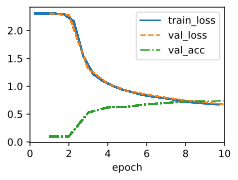

In [7]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

## **8.1. 深度卷积神经网络（AlexNet）（Deep Convolutional Neural Networks (AlexNet)）**

在 LeNet 提出后的将近 20 年里，神经网络一度被其他机器学习方法超越，如支持向量机。虽然 LeNet 可以在早期的小数据集上取得好的成绩，但是在更大的真实数据集上的表现并不尽如人意。一方面，神经网络计算复杂。虽然 20 世纪 90 年代也有过一些针对神经网络的加速硬件，但并没有像之后 GPU 那样大量普及。因此，训练一个多通道、多层和有大量参数的卷积神经网络在当年很难完成。另一方面，当年研究者还没有大量深入研究参数初始化和非凸优化算法等诸多领域，导致复杂的神经网络的训练通常较困难。

我们在上一节看到，**神经网络可以直接基于图像的原始像素进行分类**。这种称为 **端到端（*end-to-end*）** 的方法节省了很多中间步骤。然而，在很长一段时间里更流行的是研究者通过勤劳与智慧所设计并生成的手工特征。这类图像分类研究的主要流程是：

1. 获取图像数据集；
2. 使用已有的特征提取函数生成图像的特征；
3. 使用机器学习模型对图像的特征分类。

当时认为的机器学习部分仅限最后这一步。如果那时候跟机器学习研究者交谈，他们会认为机器学习既重要又优美。优雅的定理证明了许多分类器的性质。机器学习领域生机勃勃、严谨而且极其有用。然而，如果跟计算机视觉研究者交谈，则是另外一幅景象。他们会告诉你图像识别里“不可告人”的现实是：计算机视觉流程中真正重要的是数据和特征。也就是说，**使用较干净的数据集和较有效的特征甚至比机器学习模型的选择对图像分类结果的影响更大**。

###**8.1.1. 学习特征表示（Representation Learning）**

既然 **特征（*features*）** 如此重要，它该如何 **表示（*Representation*）** 呢？我们已经提到，在相当长的时间里，特征都是 **基于各式各样手工设计的函数从数据中提取的**。事实上，不少研究者通过提出新的特征提取函数不断改进图像分类结果。这一度为计算机视觉的发展做出了重要贡献。

然而，另一些研究者则持异议。他们认为 **特征本身也应该由学习得来**。他们还相信，为了表征足够复杂的输入，特征本身应该分级表示。持这一想法的研究者相信，多层神经网络可能可以学得数据的多级表征，并逐级表示越来越抽象的概念或模式。以图像分类为例，并回忆二维卷积层中物体边缘检测的例子。在多层神经网络中，图像的第一级的表示可以是在特定的位置和⻆度是否出现边缘；而第二级的表示说不定能够将这些边缘组合出有趣的模式，如花纹；在第三级的表示中，也许上一级的花纹能进一步汇合成对应物体特定部位的模式。这样逐级表示下去，最终，模型能够较容易根据最后一级的表示完成分类任务。需要强调的是，输入的逐级表示由多层模型中的参数决定，而这些**参数都是学出来的**。

第一个现代 CNN 以其发明者之一 Alex Krizhevsky 的名字命名为 **AlexNet**，主要**是对 LeNet 的进化改进**。它在 2012 年的 ImageNet 挑战赛中取得了优异的成绩。AlexNet (2012) 及其前身 LeNet (1995) 共享许多架构元素。下图是由 AlexNet 第一层学习到的特征图像：

<center><img src="https://drive.google.com/uc?export=view&id=1BKYPLH6XxfSjm-Fai_KhQbfsXPJ0AV3T" width=450px /></center>


尽管一直有一群执着的研究者不断钻研，试图学习视觉数据的逐级表征，然而很长一段时间里这些野心都未能实现。这其中有诸多因素值得我们一一分析。

**8.1.1.1. 缺失要素一：数据（Missing Ingredient: Data）**

包含许多特征的深度模型**需要大量的有标签的数据**才能表现得比其他经典方法更好。限于早期计算机有限的存储和90年代有限的研究预算，大部分研究只基于小的公开数据集。例如，不少研究论文基于加州大学欧文分校（UCI）提供的若干个公开数据集，其中许多数据集只有几百至几千张图像。这一状况在2010年前后兴起的大数据浪潮中得到改善。特别是，2009年诞生的 ImageNet 数据集包含了 1,000 大类物体，每类有多达数千张不同的图像。这一规模是当时其他公开数据集无法与之相提并论的。 ImageNet 数据集同时推动计算机视觉和机器学习研究进入新的阶段，使此前的传统方法不再有优势。

**8.1.1.2. 缺失要素二：硬件（Missing Ingredient: Hardware）**

深度学习对**计算资源要求很高**。早期的硬件计算能力有限，这使训练较复杂的神经网络变得很困难。然而，通用 GPU 的到来改变了这一格局。很久以来，GPU 都是为图像处理和计算机游戏设计的，尤其是针对大吞吐量的矩阵和向量乘法从而服务于基本的图形变换。值得庆幸的是，这其中的数学表达与深度网络中的卷积层的表达类似。通用 GPU 这个概念在 2001 年开始兴起，涌现出诸如 OpenCL 和 CUDA 之类的编程框架。这使得 **GPU 也在 2010 年前后开始被机器学习社区使用**。

### **8.1.2. AlexNet**

2012年，AlexNet 横空出世。这个模型的名字来源于论文第一作者的姓名 Alex Krizhevsky。AlexNet 使用了 8 层卷积神经网络，并以很大的优势赢得了 ImageNet 2012 图像识别挑战赛。它首次证明了学习到的特征可以超越手工设计的特征，从而一举打破计算机视觉研究的前状。

<center><img src="https://drive.google.com/uc?export=view&id=1V_AHQRvPqeXo0o4ynSqD04E92PacUeN4" width=400px /></center>

AlexNet与LeNet的设计理念非常相似，但也有显著的区别。

**8.1.2.1. 设计框架（Architecture）**

**第一，与相对较小的 LeNet 相比，AlexNet 包含 8 层变换，其中有 5 层卷积和 2 层全连接隐藏层，以及 1 个全连接输出层**。AlexNet 第一层中的卷积窗口形状是 $11×11$。因为 ImageNet 中绝大多数图像的高和宽均比 MNIST 图像的高和宽大 10 倍以上，ImageNet 图像的物体占用更多的像素，所以需要更大的卷积窗口来捕获物体。第二层中的卷积窗口形状减小到 $5×5$，之后全采用 $3×3$。此外，第一、第二和第五个卷积层之后都使用了窗口形状为 $3×3$、步幅为 2 的最大池化层。而且，AlexNet 使用的卷积通道数也大于 LeNet 中的卷积通道数数十倍。

紧接着最后一个卷积层的是两个输出个数为 4096 的全连接层。这两个巨大的全连接层带来将近 1 GB的模型参数。由于早期显存的限制，最早的 AlexNet 使用双数据流的设计使一个 GPU 只需要处理一半模型。幸运的是，显存在过去几年得到了长足的发展，因此通常我们不再需要这样的特别设计了。

**8.1.2.2. 激活函数（Activation Functions）**

**第二，AlexNet 将 sigmoid 激活函数改成了更加简单的 ReLU 激活函数**。一方面，ReLU 激活函数的计算更简单，例如它并没有 sigmoid 激活函数中的求幂运算。另一方面，ReLU 激活函数在不同的参数初始化方法下使模型更容易训练。这是由于当 sigmoid 激活函数输出极接近 0 或 1 时，这些区域的梯度几乎为 0，从而造成反向传播无法继续更新部分模型参数；而 ReLU 激活函数在正区间的梯度恒为 1。因此，若模型参数初始化不当，sigmoid 函数可能在正区间得到几乎为 0 的梯度，从而令模型无法得到有效训练。

**8.1.2.3. 容量控制和预处理（Capacity Control and Preprocessing）**

**第三，AlexNet 通过 丢弃法（*dropout*）控制全连接层的模型复杂度，而 LeNet 只使用权重衰减**。为了进一步增强数据，AlexNet 的训练循环添加了大量图像增强，例如翻转、裁剪和颜色变化。这使得模型更加健壮，更大的样本量有效地减少了过拟合。

下面我们实现稍微简化过的 AlexNet:

In [8]:
import torch
from torch import nn
from d2l import torch as d2l

In [9]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

我们构建了一个单通道数据示例，高和宽均为 224，以观察每一层的输出形状:

In [10]:
AlexNet().layer_summary((1, 1, 224, 224))

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

### **8.1.3. 训练（*Training*）**

尽管 AlexNet 在 `ImageNet` 上进行了训练 。我们在这里使用 `Fashion-MNIST`，因为即使在现代 GPU 上训练 ImageNet 模型收敛也可能需要数小时或数天。直接在 `Fashion-MNIST` 上应用 AlexNet 的问题之一是它的图像分辨率较低（$28 \times 28$ 像素）比 `ImageNet` 图像。为了使事情正常进行，我们将它们上采样到 $224 \times 224$. 这通常不是一个明智的做法，因为它只是增加了计算的复杂性而没有增加信息。尽管如此，我们在这里这样做是为了忠实于 `AlexNet` 架构。`resize` 我们使用构造函数中的参数执行此大小调整 `d2l.FashionMNIST`。

现在，我们可以开始训练 AlexNet。与 LeNet 相比，这里的主要变化是使用更小的学习率和更慢的训练，因为网络更深更宽，图像分辨率更高，卷积成本更高。

In [ ]:
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)